In [ ]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers, Model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
dataset_path = r'E:\Masters\CVIP\BIM Dataset V3\BIM Dataset V3'

data = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_samples = sum(
            len(files) for _, _, files in os.walk(class_path)
        )
        data.append({
            "class_name": class_name,
            "num_samples": num_samples
        })

df = pd.DataFrame(data)

gestures = list(df.sort_values(by='num_samples', ascending = False).head(30)['class_name'])



In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion from BGR to RGB
    image.flags.writeable = False                   # Image is no longer writeable
    results = model.process(image)                  # Make prediction
    image.flags.writeable = True                    # Image is no longer writeable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)   # Color conversion RGB to BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    # Draw right connections

def draw_styled_landmarks(image,results):

    # Draw pose connection
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )
    # Draw left hand connection
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=2),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )
    # Draw right hand connection
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=2),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose, lh, rh])

def detect_hand_landmarks(image_path):
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Make detections
        image, results = mediapipe_detection(image, holistic)

        # Draw landmarks to the frame
        draw_styled_landmarks(image,results)

        # Convert the image back to BGR for OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Display the image with hand landmarks
        cv2.imshow('Hand Landmarks', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


In [ ]:
# Specify your path to store landmarks files
train_dataset_path = r'E:\Masters\CVIP\train_dataset'
video_directory = r'E:\Masters\CVIP\BIM Dataset V3\BIM Dataset V3'
for ges in gestures:

    # Specify the video path

    data_path = os.path.join(video_directory, ges)
    data_video = os.listdir(data_path)

    for vid in data_video:

        if not os.path.exists(os.path.join(train_dataset_path)):
            os.makedirs(train_dataset_path)

        landmark_path = os.path.join(train_dataset_path, ges, 'landmarks_' + vid.split('.')[0])
        video_path = os.path.join(video_directory, ges, vid)
        print(video_path)


        # Locate the video dataset
        video = cv2.VideoCapture(video_path)

        count = 0
        frame_count = 0

        # Set mediapipe model
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            while True:
                ret, frame = video.read()

                if not ret or frame_count == 30:
                    # Break the loop if there are no more frames
                    break

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks to the frame
                draw_styled_landmarks(image,results)

                # Check if hands are present
                # This part ensures that only frames with detected hand landmarks are saved.
                if results.left_hand_landmarks or results.right_hand_landmarks:

                    # Create landmark files
                    if not os.path.exists(landmark_path):
                        os.makedirs(landmark_path)

                    # Extract keypoint
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(landmark_path, str(count + 1))
                    np.save(npy_path, keypoints)
                    print(f"Extract: {npy_path}")

                    frame_count += 1

                count += 1



In [ ]:
label_map = {label: num for num, label in enumerate(gestures)}

gesture_sequence, labels = [], []

for gs in gestures:
    gesture = []

    for fname in os.listdir(os.path.join(train_dataset_path, gs)):
        path = os.ath.join(train_dataset_path, gs, fname)
        if os.path.isdir(path):
            gesture.append(fname)

    for no in gesture:
        load_path = os.path.join(train_dataset_path, gs, no)
        npy_files = sorted([f for f in os.listdir(load_path) if f.endswith('.npy')])
        npy_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

        video = []
        for npy in npy_files:
            video.append(np.load(os.path.join(load_path, npy)))
            print(os.path.join(load_path, npy))

        gesture_sequence.append(video)
        labels.append(label_map[gs])

    # Calculate the maximum sequence length for this gesture
    max_len = max(len(seq) for seq in gesture_sequence)

    # Pad shorter sequences with zeros to match the maximum length
    gesture_sequence = [
        seq + [[0] * seq[0].shape[0]] * (max_len - len(seq))  # Pad with zeros
        for seq in gesture_sequence
    ]

    print(np.array(gesture_sequence).shape, np.array(labels).shape)

X = np.array(gesture_sequence)
y = np.array(labels)

np.save(r'E:\Masters\CVIP\x_train.npy', X)
np.save(r'E:\Masters\CVIP\y_train.npy', y)

In [18]:
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3083, 30, 258), (163, 30, 258), (3083, 30), (163, 30))

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_gesture_transformer(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Dense(128)(inputs) 
    
    x = transformer_encoder(x, head_size=128, num_heads=4, ff_dim=256, dropout=0.1)
    x = transformer_encoder(x, head_size=128, num_heads=4, ff_dim=256, dropout=0.1)

    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

model = build_gesture_transformer((30, 258), 30)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - categorical_accuracy: 0.1430 - loss: 3.1180 - val_categorical_accuracy: 0.2147 - val_loss: 2.7973 - learning_rate: 1.0000e-04
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - categorical_accuracy: 0.2416 - loss: 2.6785 - val_categorical_accuracy: 0.3865 - val_loss: 2.3060 - learning_rate: 1.0000e-04
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - categorical_accuracy: 0.3312 - loss: 2.2439 - val_categorical_accuracy: 0.4663 - val_loss: 1.8386 - learning_rate: 1.0000e-04
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - categorical_accuracy: 0.4453 - loss: 1.8143 - val_categorical_accuracy: 0.5583 - val_loss: 1.5799 - learning_rate: 1.0000e-04
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - categorical_accuracy: 0.4963 - loss: 1.5791 - val_categorical_accuracy: 0.5951 - val_loss: 1.2933 - learning_rate: 1.0000e-04
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - categorical_accuracy: 0.5913 - loss: 1.2789 - 

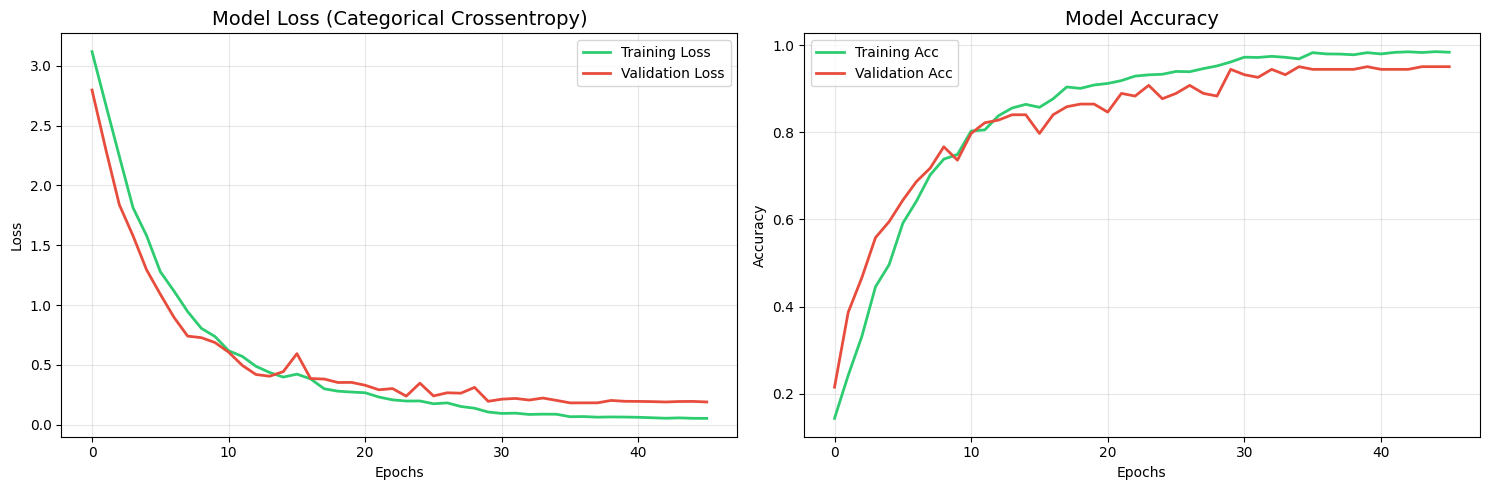

In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['loss'], label='Training Loss', color='#2ecc71', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='#e74c3c', linewidth=2)
    ax1.set_title('Model Loss (Categorical Crossentropy)', fontsize=14)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(history.history['categorical_accuracy'], label='Training Acc', color='#2ecc71', linewidth=2)
    ax2.plot(history.history['val_categorical_accuracy'], label='Validation Acc', color='#e74c3c', linewidth=2)
    ax2.set_title('Model Accuracy', fontsize=14)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run this after your model.fit()
plot_history(history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


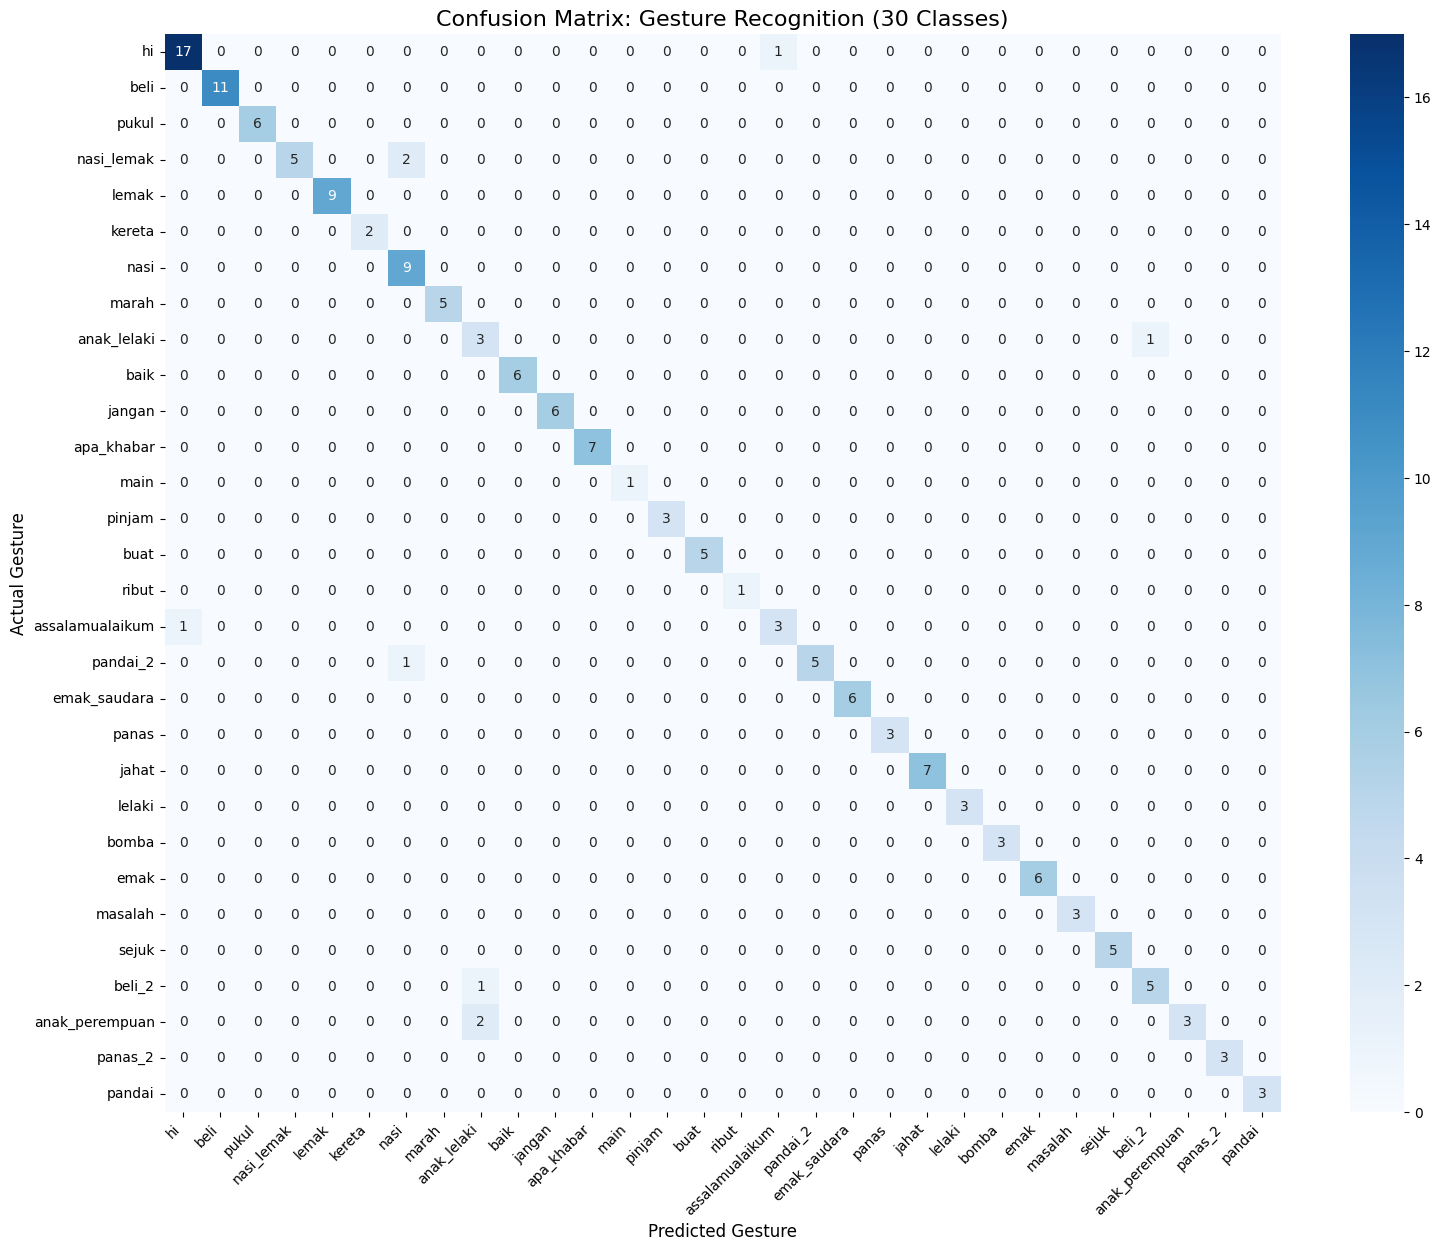

In [ ]:
y_true = np.argmax(y_test, axis=1)
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(18, 14))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=gestures, 
    yticklabels=gestures
)

plt.title('Confusion Matrix: Gesture Recognition (30 Classes)', fontsize=16)
plt.ylabel('Actual Gesture', fontsize=12)
plt.xlabel('Predicted Gesture', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

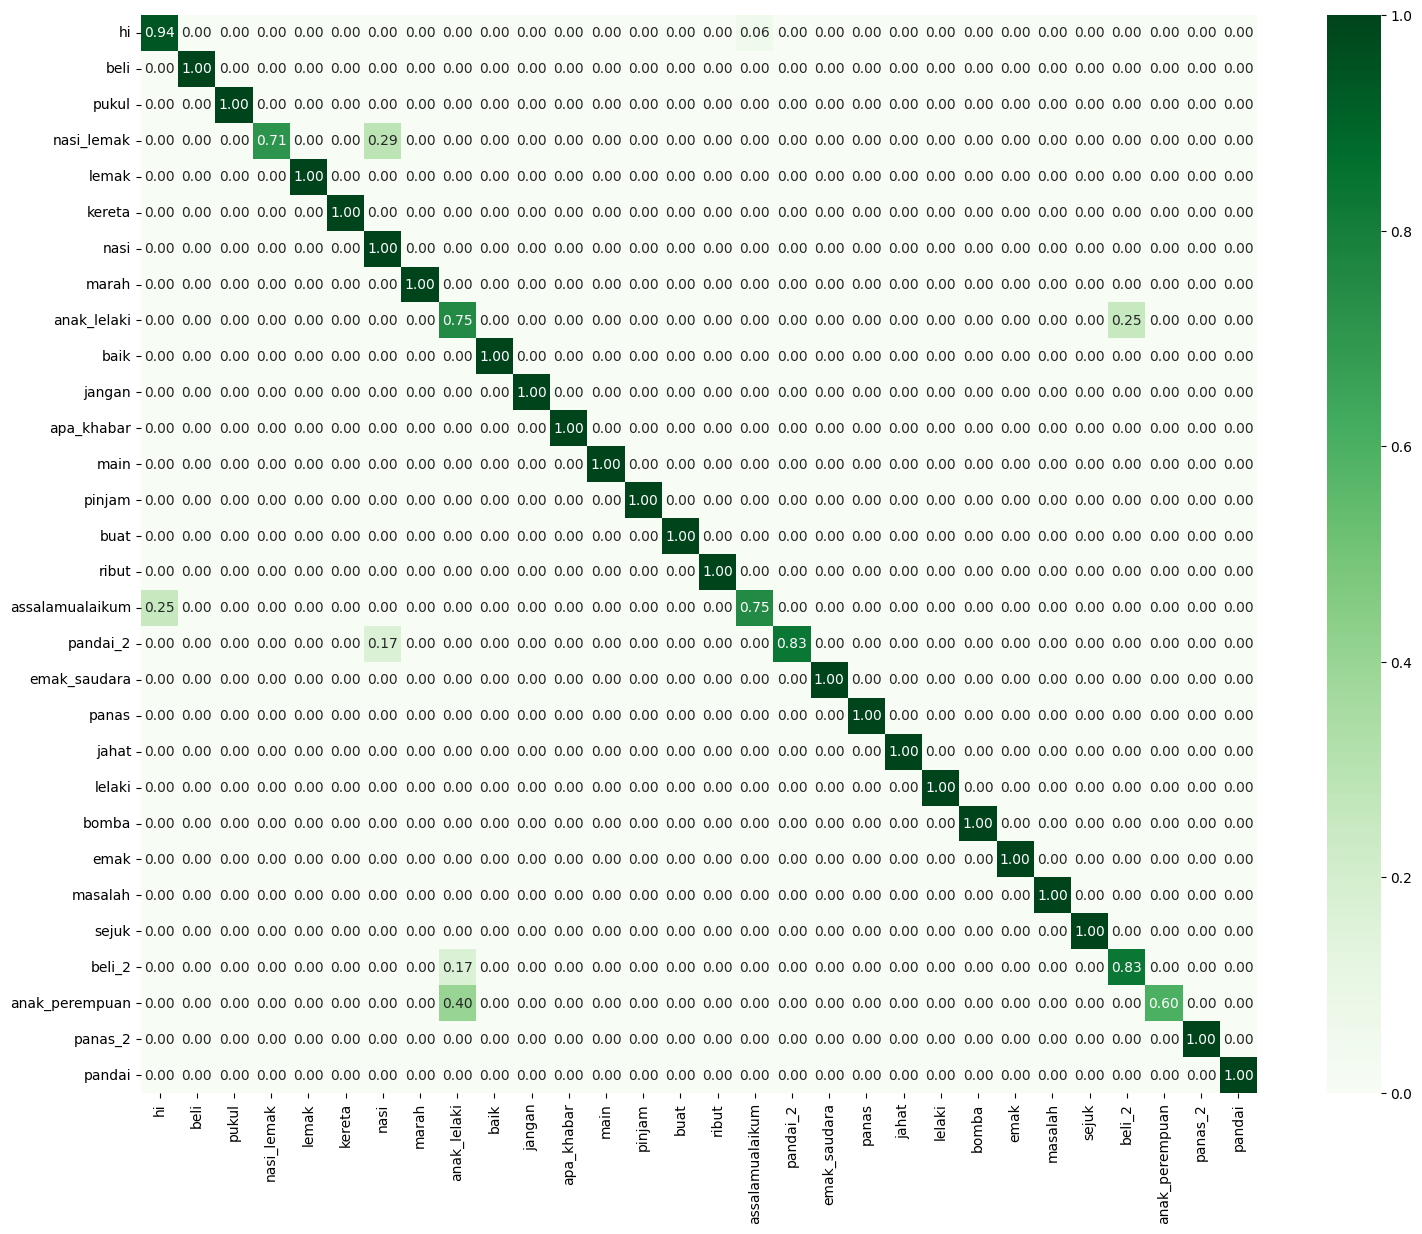

In [ ]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(18, 14))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', 
            xticklabels=gestures, yticklabels=gestures)
plt.show()